# CNN和ResNet

## 1. 加载相关库

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt

## 2. 下载和加载MNIST数据集

In [4]:
torchvision.datasets

<module 'torchvision.datasets' from '/Users/hanz/anaconda3/lib/python3.11/site-packages/torchvision/datasets/__init__.py'>

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                                download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                          download=True, transform=transform)



100%|██████████| 9.91M/9.91M [00:16<00:00, 610kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 106kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 734kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.1kB/s]


In [7]:
# 划分训练集和验证集（例如：50000 训练 + 10000 验证）
train_size = int(0.83 * len(full_train_dataset))  # 50000
val_size = len(full_train_dataset) - train_size   # 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 2.1 可视化单张图像

(-0.5, 27.5, 27.5, -0.5)

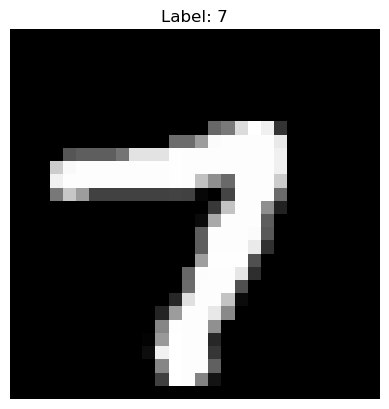

In [31]:
idx = np.random.randint(0, len(full_train_dataset))
image, label = full_train_dataset[idx]
plt.Figure(figsize=(.5,.5))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')

In [33]:
image.squeeze().shape

torch.Size([28, 28])

### 2.2 可视化多张图像

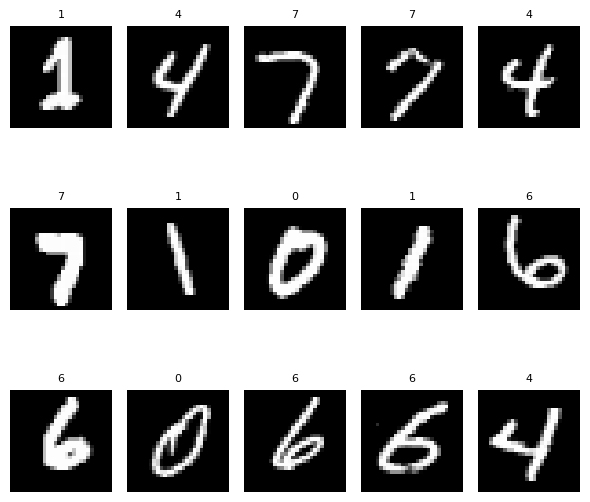

In [42]:
def show_images(dataset, num_images=15):
    idx = np.random.randint(0, len(full_train_dataset), 15)
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        image, label = dataset[idx[i]]
        plt.subplot(3, 5, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(label, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(full_train_dataset)


## 3. 构建模型

### 3.1 简单的CNN模型

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x)
        return x


In [44]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1)
        )


    def forward(self, x):
        x = self.conv(x)  # [B, 32, 14, 14]
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc(x)
        return x


In [45]:
model = SimpleCNN()
model

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=-1)
  )
)

In [96]:
X = torch.randn(4,1,28,28)
X.shape

torch.Size([4, 1, 28, 28])

In [97]:
y = model(X)
y.shape

torch.Size([4, 10])

In [98]:
y.shape

torch.Size([4, 10])

### 3.2 简化的ResNet

In [100]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.layer1 = BasicBlock(16, 32, stride=2)
        self.layer2 = BasicBlock(32, 64, stride=2)
        self.fc = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))    # [B, 16, 28, 28]
        x = self.layer1(x)                   # [B, 32, 14, 14]
        x = self.layer2(x)                   # [B, 64, 7, 7]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.softmax(x)
        return x
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            BasicBlock(16, 32, stride = 2),
            BasicBlock(32, 64, stride = 2)
        )
        
    
    def forward(x):
        x
        

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # 主路径（主干）
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # skip 路径（shortcut）
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.main(x)
        out += identity
        return F.relu(out)


In [82]:
model = ResNet()
model

ResNet(
  (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): BasicBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b

## 4. 训练过程

### 4.1 训练函数

In [101]:
def train_per_epoch(model, loader, optimizer, criterion, device, epoch, writer):
    model.train()
    running_loss, correct = 0, 0
    total = 0
    for batch_idx, (data, targets) in enumerate(loader):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    acc = correct / total
    avg_loss = running_loss / len(loader)
    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f}, Acc: {acc:.4f}")
    writer.add_scalar("Loss/train", avg_loss, epoch)
    writer.add_scalar("Accuracy/train", acc, epoch)

### 4.2 验证函数

In [103]:
def validate(model, loader, device, epoch, writer):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            val_loss += F.cross_entropy(outputs, targets, reduction='sum').item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(targets).sum().item()

    val_loss /= len(loader.dataset)
    val_acc = correct / len(loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    return val_acc

### 4.3 测试函数

In [75]:
def test(model, loader, device):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            test_loss += F.cross_entropy(outputs, targets, reduction='sum').item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(targets).sum().item()

    test_loss /= len(loader.dataset)
    test_acc = correct / len(loader.dataset)
    print(f"\n [Test Set] Average loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    return test_loss, test_acc


### 4.3 训练CNN

In [104]:
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEtropy
writer = SummaryWriter(log_dir="runs/mnist_CNN")

best_val_acc = 0.0
# 训练多个 epoch
for epoch in range(1, 11):
    train(model, train_loader, optimizer, criterion, device, epoch, writer)
    val_acc = validate(model, val_loader, device, epoch, writer)
    
   

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "CNN_best_model.pth")
        print(f"✅ 模型在 epoch {epoch} 保存，验证准确率: {val_acc:.4f}")

writer.close()

Epoch 1 - Train Loss: 1.6623, Acc: 0.8003
Validation Loss: 1.4980, Accuracy: 0.9660
✅ 模型在 epoch 1 保存，验证准确率: 0.9660
Epoch 2 - Train Loss: 1.4846, Acc: 0.9775
Validation Loss: 1.4834, Accuracy: 0.9785
✅ 模型在 epoch 2 保存，验证准确率: 0.9785
Epoch 3 - Train Loss: 1.4788, Acc: 0.9829
Validation Loss: 1.4789, Accuracy: 0.9824
✅ 模型在 epoch 3 保存，验证准确率: 0.9824
Epoch 4 - Train Loss: 1.4747, Acc: 0.9868
Validation Loss: 1.4809, Accuracy: 0.9803
Epoch 5 - Train Loss: 1.4729, Acc: 0.9886
Validation Loss: 1.4835, Accuracy: 0.9776
Epoch 6 - Train Loss: 1.4725, Acc: 0.9888
Validation Loss: 1.4783, Accuracy: 0.9827
✅ 模型在 epoch 6 保存，验证准确率: 0.9827
Epoch 7 - Train Loss: 1.4715, Acc: 0.9898
Validation Loss: 1.4797, Accuracy: 0.9817
Epoch 8 - Train Loss: 1.4709, Acc: 0.9903
Validation Loss: 1.4788, Accuracy: 0.9821
Epoch 9 - Train Loss: 1.4706, Acc: 0.9906
Validation Loss: 1.4765, Accuracy: 0.9848
✅ 模型在 epoch 9 保存，验证准确率: 0.9848
Epoch 10 - Train Loss: 1.4696, Acc: 0.9916
Validation Loss: 1.4792, Accuracy: 0.9818


### 4.4 测试CNN

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
checkpoint = torch.load('CNN_best_model.pth')
model.load_state_dict(checkpoint)

test(model, test_loader, device)



 [Test Set] Average loss: 0.0326, Accuracy: 0.9902


(0.03261887364387512, 0.9902)

### 4.5 训练ResNet

In [127]:
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter(log_dir="runs/mnist_ResNet")

best_val_acc = 0.0
# 训练多个 epoch
for epoch in range(1, 11):
    train(model, train_loader, optimizer, device, epoch, writer)
    validate(model, val_loader, device, epoch, writer)
    
    # 计算验证准确率
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    val_acc = correct / len(val_loader.dataset)

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "ResNet_best_model.pth")
        print(f"✅ 模型在 epoch {epoch} 保存，验证准确率: {val_acc:.4f}")

writer.close()

Epoch 1 - Train Loss: 0.1209, Acc: 0.9627
Validation Loss: 0.0617, Accuracy: 0.9806
✅ 模型在 epoch 1 保存，验证准确率: 0.9806
Epoch 2 - Train Loss: 0.0433, Acc: 0.9863
Validation Loss: 0.0588, Accuracy: 0.9818
✅ 模型在 epoch 2 保存，验证准确率: 0.9818
Epoch 3 - Train Loss: 0.0290, Acc: 0.9907
Validation Loss: 0.0361, Accuracy: 0.9890
✅ 模型在 epoch 3 保存，验证准确率: 0.9890
Epoch 4 - Train Loss: 0.0220, Acc: 0.9926
Validation Loss: 0.0572, Accuracy: 0.9842
Epoch 5 - Train Loss: 0.0167, Acc: 0.9943
Validation Loss: 0.0413, Accuracy: 0.9873
Epoch 6 - Train Loss: 0.0143, Acc: 0.9952
Validation Loss: 0.0435, Accuracy: 0.9896
✅ 模型在 epoch 6 保存，验证准确率: 0.9896
Epoch 7 - Train Loss: 0.0099, Acc: 0.9966
Validation Loss: 0.0449, Accuracy: 0.9881
Epoch 8 - Train Loss: 0.0112, Acc: 0.9963
Validation Loss: 0.0491, Accuracy: 0.9875
Epoch 9 - Train Loss: 0.0087, Acc: 0.9970
Validation Loss: 0.0516, Accuracy: 0.9881
Epoch 10 - Train Loss: 0.0089, Acc: 0.9972
Validation Loss: 0.0494, Accuracy: 0.9872


### 4.6 测试ResNet

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
checkpoint = torch.load('CNN_best_model.pth')
model.load_state_dict(checkpoint)

test(model, test_loader, device)


 [Test Set] Average loss: 0.0536, Accuracy: 0.9867


(0.05361763286590576, 0.9867)

In [60]:
!pip install --upgrade tensorboard

  Obtaining dependency information for tensorboard from https://files.pythonhosted.org/packages/5d/12/4f70e8e2ba0dbe72ea978429d8530b0333f0ed2140cc571a48802878ef99/tensorboard-2.19.0-py3-none-any.whl.metadata
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.1 kB/s eta 0:00:0000:0100:06
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.1
    Uninstalling tensorboard-2.12.1:
      Successfully uninstalled tensorboard-2.12.1


In [66]:
!pip install tensorflow  --no-deps

In [67]:
!pip install tensorboard

In [ ]:
!pip install